# マルコフ連鎖モンテカルロ法 (MCMC)
前節では解析的に事後分布の計算をした．事後分布を近似的に推論する方法の1つに**マルコフ連鎖モンテカルロ法 (Markov chain Monte Carlo methods; MCMC)** がある．他の近似推論の手法としてはLaplace近似や変分推論（variational inference）などがある．MCMCは他の手法に比して，事後分布の推論だけでなく，確率分布を神経活動で表現する方法を提供するという利点がある．

データを$X$とし，パラメータを$\theta$とする．

$$
\begin{equation}
p(\theta\mid X)=\frac{p(X\mid \theta)p(\theta)}{\int p(X\mid \theta)p(\theta)d\theta}
\end{equation}
$$

分母の積分計算$\int p(X\mid \theta)p(\theta)d\theta$が求まればよい．

### モンテカルロ法

### マルコフ連鎖


## Metropolis-Hastings法


In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff, KernelDensity
rc("axes.spines", top=false, right=false)

In [2]:
mixed_gauss = MixtureModel([MvNormal(zeros(2), I), MvNormal(3*ones(2), I)], [0.5, 0.5]) # 分布を混ぜる

MixtureModel{IsoNormal}(K = 2)
components[1] (prior = 0.5000): IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.0; 0.0 1.0]
)

components[2] (prior = 0.5000): IsoNormal(
dim: 2
μ: [3.0, 3.0]
Σ: [1.0 0.0; 0.0 1.0]
)



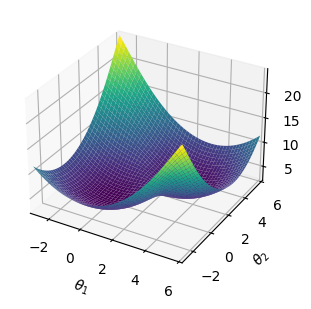

In [3]:
x = -3:0.1:6
pd(x₁, x₂) = logpdf(mixed_gauss, [x₁, x₂])

mixed_gauss_heat = pd.(x, x');

xpos = x * ones(size(x))'

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(xpos, xpos', -mixed_gauss_heat, cmap="viridis")
ax.set_xlim(-3, 6); ax.set_ylim(-3, 6); 
ax.set_xlabel(L"$\theta_1$"); ax.set_ylabel(L"$\theta_2$"); ax.set_zlabel(L"$-\log p$"); 
tight_layout()

Metropolis-Hastings法における採用・不採用アルゴリズム．

In [4]:
# Metropolis-Hastings method; log_p: unnormalized log-posterior
function gaussian_mh(log_p::Function, θ_init::Vector{Float64}, σ::Float64, num_iter::Int)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        θ_ = rand(MvNormal(θ, σ*I))
        mH = log_p(θ) + logpdf(MvNormal(θ, σ*I), θ_)       # initial Hamiltonian
        mH_ = log_p(θ_) + logpdf(MvNormal(θ_, σ*I), θ)    # final Hamiltonian
        
        if min(1, exp(mH_ - mH)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [5]:
log_p(θ) = logpdf(mixed_gauss, θ);
grad(θ)= ForwardDiff.gradient(log_p, θ)

grad (generic function with 1 method)

In [6]:
θm, num_accepted = gaussian_mh(log_p, [1.0,0.5], 1.0, 2000)

([1.0 1.0 … 0.4331052638968813 0.11221124838455171; 0.5 0.5 … 2.002625214513086 1.979212663395787], 1183)

In [7]:
size(θm)

(2, 2000)

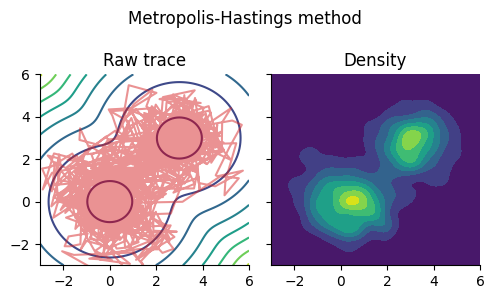

In [8]:
Um = kde((θm[1, :], θm[2, :]));

fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Metropolis-Hastings method")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θm[1, :], θm[2, :], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Um.x, Um.x, Um.density)
fig.tight_layout()

## ランジュバン・モンテカルロ法 (LMC)
拡散過程

$$
\begin{equation}
{\frac{d\theta}{dt}}=\nabla \log p (\theta)+{\sqrt 2}{d{W}}
\end{equation}
$$

Euler–Maruyama法により，

In [9]:
nt = 10000
ϵ = 0.1

0.1

In [10]:
β = 1
ρ = sqrt(2*ϵ);

In [11]:
θl = zeros(nt, 2)
θ = [1.0,0.5]
for t in 1:nt
    θ += ϵ * β * grad(θ) + ρ * randn(2)
    θl[t, :] = θ
end

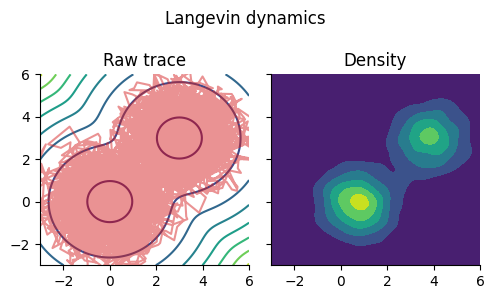

In [12]:
Ul = kde((θl[:, 1], θl[:, 2]));

fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Langevin dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θl[:, 1], θl[:, 2], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Ul.x, Ul.x, Ul.density)
fig.tight_layout()

## ハミルトニアン・モンテカルロ法 (HMC法)

LMCよりも一般的なMCMCの手法としてHamiltonianモンテカルロ法(Hamiltonian Monte Calro; HMC)あるいはハイブリッド・モンテカルロ法(Hybrid Monte Calro)がある．エネルギーポテンシャルの局面上をHamilton力学に従ってパラメータを運動させることにより高速にサンプリングする手法である．

一般化座標を$\mathbf{q}$, 一般化運動量を$\mathbf{p}$とする．ポテンシャルエネルギーを$U(\mathbf{q})$としたとき，古典力学（解析力学）において保存力のみが作用する場合の**ハミルトニアン (Hamiltonian)** $\mathcal{H}(\mathbf{q}, \mathbf{p})$は

$$
\begin{equation}
\mathcal{H}(\mathbf{q}, \mathbf{p}):=U(\mathbf{q})+\frac{1}{2}\|\mathbf{p}\|^2
\end{equation}
$$

となる．このとき，次の2つの方程式が成り立つ．

$$
\begin{equation}
\frac{d\mathbf{q}}{dt}=\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p},\quad\frac{d\mathbf{p}}{dt}=-\frac{\partial \mathcal{H}}{\partial \mathbf{q}}=-\frac{\partial U}{\partial \mathbf{q}}
\end{equation}
$$

これを**ハミルトンの運動方程式(hamilton's equations of motion)** あるいは**正準方程式 (canonical equations)** という．



リープフロッグ(leap frog)法により離散化する．

In [13]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [14]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function hmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, num_iter::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [15]:
ps = zeros(nt, 2)
θs = zeros(nt, 2)
p = randn(2)
θ = randn(2)
for t in 1:nt
    if t in 20:10:nt
        p = randn(2)
    end
    p += 0.5 * ϵ * grad(θ)
    θ += ϵ * p
    p += 0.5 * ϵ * grad(θ)
    ps[t, :] = p
    θs[t, :] = θ
end

In [16]:
Us = kde((θs[:, 1], θs[:, 2]));

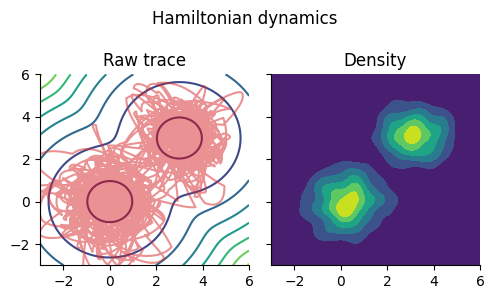

In [17]:
fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Hamiltonian dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θs[:, 1], θs[:, 2], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Us.x, Us.x, Us.density)
fig.tight_layout()

*ToDo: 自己相関確認する*

## 線形回帰への適応


In [18]:
# Generate Toy datas
num_train, num_test = 20, 100 # sample size
dims = 4 # dimensions
σy = 0.3

polynomial_expansion(x; degree=3) = stack([x .^ p for p in 0:degree]);

Random.seed!(0);
x = rand(num_train)
y = sin.(2π*x) + σy * randn(num_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=num_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

In [19]:
log_joint(w, ϕ, y, σy, μ₀, Σ₀) = sum(logpdf.(Normal.(ϕ * w, σy), y)) + logpdf(MvNormal(μ₀, Σ₀), w);

In [20]:
α, β = 5e-3, 5.0

(0.005, 5.0)

In [21]:
w = randn(dims)
μ₀ = zeros(dims)
Σ₀ = 1/α * I;

In [22]:
ulp(w) = log_joint(w, ϕ, y, σy, μ₀, Σ₀)

ulp (generic function with 1 method)

In [23]:
w_init = rand(MvNormal(μ₀, Σ₀), 1)[:, 1]

4-element Vector{Float64}:
  2.3512978351397225
  4.110944423223151
 12.557040811868173
 -2.261645476785874

In [24]:
@time samples, num_accepted = hmc(ulp, w_init, 1e-2, 10, 500)

  0.667739 seconds (1.78 M allocations: 142.952 MiB, 4.79% gc time, 95.12% compilation time)


([-3.8156314393886377 -1.8368821823332713 … 1.6762101979567923 1.7090983656704202; -0.22189176403231914 0.07900270653627536 … -7.034942662595455 -6.8996980791778695; 9.246551622910427 9.142407414249368 … 6.448467257423472 6.416028849063524; -4.838257185223667 -4.771434190569835 … -1.6832576081376387 -1.7626363212762015], 499)

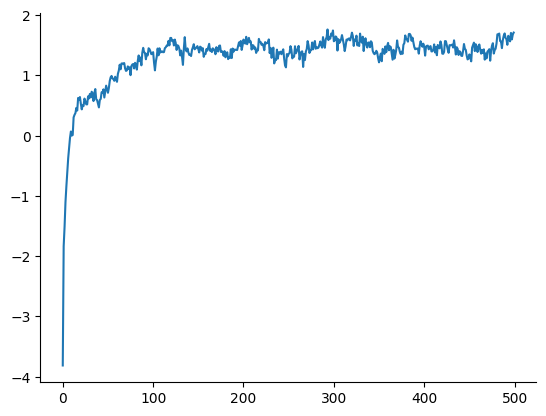

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001BB02AA6050>

In [25]:
plot(samples[1, :])

In [26]:
yhmc = ϕtest * samples[:, 300:end];
yhmc_mean = mean(yhmc, dims=2)[:];
yhmc_std = std(yhmc, dims=2)[:];

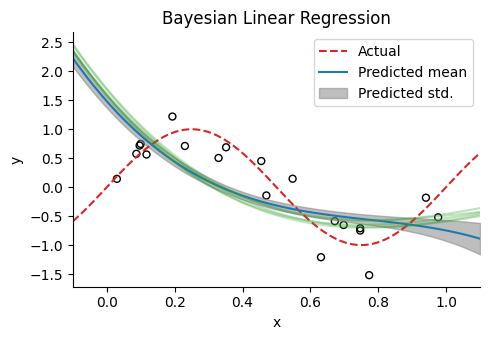

In [27]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, yhmc_mean, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, yhmc_mean+yhmc_std, yhmc_mean-yhmc_std, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:5
    plot(xtest, yhmc[:, end-i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()